# Intake


<div class="alert-info">

### Overview
    
* **teaching:** 20 minutes
* **exercises:** 0
* **questions:**
    * How does Intake simplify data discovery, distribution, and loading?
</div>

### Table of contents
1. [**Intake primer**](#Intake-primer)
1. [**Build and intake catalog**](#Build-an-intake-catalog)
1. [**Work with an intake catalog**](#Work-with-an-intake-catalog)
1. [**Intake xarray example**](#Intake-xarray-example)
1. [**Intake STAC example**](#Intake-STAC-example)

## Intake primer

<img src="https://intake.readthedocs.io/en/latest/_static/images/logo.png" alt="intake logo" width="200" align="right"/>


[Intake](https://intake.readthedocs.io/en/latest/index.html) is a lightweight package for finding, investigating, loading and disseminating data. This notebook illutrates the usefulness of intake for a "Data User". Intake simplifies loading data from [many formats](https://intake.readthedocs.io/en/latest/plugin-directory.html#plugin-directory) into familiar Python objects like Pandas DataFrames or Xarray Datasets. Intake is especially useful for remote datasets - it allows us to bypass downloading data and instead load directly into a Python object for analysis. 

## Build an intake catalog

Let's say we want to save a version of the data from our geopandas.ipynb tutorial for easy sharing and future use. intake has csv support by default but for loading data with geopandas we need to make sure the [intake_geopandas plugin](https://github.com/intake/intake_geopandas) is installed.

In [42]:
import intake
import xarray

print(intake.__version__)
xarray.set_options(display_style="html")

0.5.3


In [2]:
# Save data locally from our queries
import pandas as pd
import geopandas as gpd

server = 'https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?'
query = 'service=WFS&version=2.0.0&request=GetFeature&typeName=GVP-VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv'
df = pd.read_csv(server+query)
df.to_csv('votw.csv', index=False)

# Or save as geojson
# Now load query results as json directly in geopandas
query = 'service=WFS&version=2.0.0&request=GetFeature&typeName=GVP-VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=json'
gf = gpd.read_file(server+query)
gf.to_file('votw.geojson', driver='GeoJSON')

In [3]:
%%writefile votw-intake-catalog.yaml

metadata:
  version: 1

sources:
  votw_pandas:
    args:
      csv_kwargs:
        blocksize: null #prevent reading in parallel with dask
      #urlpath: 'https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=2.0.0&request=GetFeature&typeName=GVP-VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv'
      urlpath: './votw.csv'
    description: 'Smithsonian_VOTW_Holocene_Volcanoes 4.8.4'
    driver: csv
    metadata:
      citation: 'Global Volcanism Program, 2013. Volcanoes of the World, v. 4.8.4. Venzke, E (ed.). Smithsonian Institution. Downloaded 06 Dec 2019. https://doi.org/10.5479/si.GVP.VOTW4-2013'
      plots:
        last_eruption_year:
          kind: violin
          by: 'Region'
          y: 'Last_Eruption_Year'
          invert: True
          width: 700
          height: 500
            
            
  votw_geopandas:
    args:
      #urlpath: 'https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=2.0.0&request=GetFeature&typeName=GVP-VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=json'
      urlpath: './votw.geojson'
    description: 'Smithsonian_VOTW_Holocene_Volcanoes 4.8.4'
    driver: geojson
    metadata:
      citation: 'Global Volcanism Program, 2013. Volcanoes of the World, v. 4.8.4. Venzke, E (ed.). Smithsonian Institution. Downloaded 06 Dec 2019. https://doi.org/10.5479/si.GVP.VOTW4-2013'

Writing votw-intake-catalog.yaml


In [4]:
# put this catalog, votw.csv, and votw.geojson, in a public place like GitHub!
# This facilitates sharing and version controlled analysis
cat = intake.open_catalog('votw-intake-catalog.yaml')

In [5]:
print(list(cat))
cat.votw_pandas.description

['votw_pandas', 'votw_geopandas']


'Smithsonian_VOTW_Holocene_Volcanoes 4.8.4'

In [6]:
# Loading the data is now very straightforward:
# We know the data will be read into a Pandas DataFrame because
cat.votw_pandas.container

'dataframe'

In [7]:
df = cat.votw_pandas.read()
df.head()

FID  Volcano_Number  \
0  Smithsonian_VOTW_Holocene_Volcanoes.fid--77a2b...          210010   
1  Smithsonian_VOTW_Holocene_Volcanoes.fid--77a2b...          210020   
2  Smithsonian_VOTW_Holocene_Volcanoes.fid--77a2b...          210030   
3  Smithsonian_VOTW_Holocene_Volcanoes.fid--77a2b...          210040   
4  Smithsonian_VOTW_Holocene_Volcanoes.fid--77a2b...          211003   

                Volcano_Name Primary_Volcano_Type  Last_Eruption_Year  \
0  West Eifel Volcanic Field              Maar(s)             -8300.0   
1            Chaine des Puys         Lava dome(s)             -4040.0   
2        Olot Volcanic Field  Pyroclastic cone(s)                 NaN   
3   Calatrava Volcanic Field  Pyroclastic cone(s)             -3600.0   
4                    Vulsini              Caldera              -104.0   

   Country                                 Geological_Summary  \
0  Germany  The West Eifel Volcanic Field of western Germa...   
1   France  The Chaîne des Puys, prominent in the history ...   
2    Spain  The Olot volcanic field (also known as the Gar...   
3    Spain  The Calatrava volcanic field lies in central S...   
4    Italy  The Vulsini volcanic complex in central Italy ...   

                           Region       Subregion  Latitude  Longitude  \
0  Mediterranean and Western Asia  Western Europe    50.170       6.85   
1  Mediterranean and Western Asia  Western Europe    45.775       2.97   
2  Mediterranean and Western Asia  Western Europe    42.170       2.53   
3  Mediterranean and Western Asia  Western Europe    38.870      -4.02   
4  Mediterranean and Western Asia           Italy    42.600      11.93   

   Elevation                               Tectonic_Setting Geologic_Epoch  \
0        600        Rift zone / Continental crust (> 25 km)       Holocene   
1       1464        Rift zone / Continental crust (> 25 km)       Holocene   
2        893       Intraplate / Continental crust (> 25 km)       Holocene   
3       1117       Intraplate / Continental crust (> 25 km)       Holocene   
4        800  Subduction zone / Continental crust (> 25 km)       Holocene   

   Evidence_Category                             Primary_Photo_Link  \
0     Eruption Dated  https://volcano.si.edu/photos/full/015001.jpg   
1     Eruption Dated  https://volcano.si.edu/photos/full/088002.jpg   
2  Evidence Credible  https://volcano.si.edu/photos/full/119091.jpg   
3     Eruption Dated  https://volcano.si.edu/photos/full/118054.jpg   
4  Eruption Observed  https://volcano.si.edu/photos/full/015006.jpg   

                               Primary_Photo_Caption  \
0  The lake-filled Weinfelder maar is one of abou...   
1  The central part of the Chaîne des Puys volcan...   
2  The forested Volcà Montolivet cinder cone rise...   
3  Columba volcano, the youngest dated vent of th...   
4  The 16-km-wide Bolsena caldera, filled by the ...   

                                Primary_Photo_Credit  \
0  Photo by Richard Waitt, 1990 (U.S. Geological ...   
1       Photo by Ichio Moriya (Kanazawa University).   
2            Photo by Puigalder (Wikimedia Commons).   
3  Photo by Rafael Becerra Ramírez, 2006 (Univers...   
4  Photo by Richard Waitt, 1985 (U.S. Geological ...   

                    Major_Rock_Type          GeoLocation  
0                           Foidite   POINT (50.17 6.85)  
1             Basalt / Picro-Basalt  POINT (45.775 2.97)  
2  Trachybasalt / Tephrite Basanite   POINT (42.17 2.53)  
3             Basalt / Picro-Basalt  POINT (38.87 -4.02)  
4           Trachyte / Trachydacite   POINT (42.6 11.93)

In [8]:
# Notice we also specified some pre-defined plots in the catalog
# This requires hvplot
import hvplot.pandas
source = cat.votw_pandas
source.plot.last_eruption_year()

:Violin   [Region]   (Last_Eruption_Year)

In [9]:
# Load a different dataset in the same catalog
source = cat.votw_geopandas
source.description

'Smithsonian_VOTW_Holocene_Volcanoes 4.8.4'

In [10]:
gf = source.read()
test = gf.loc[:,['Last_Eruption_Year', 'Volcano_Name', 'geometry']]
test.hvplot.points(geo=True, hover_cols=['Volcano_Name'], color='Last_Eruption_Year')

:Points   [Longitude,Latitude]   (Last_Eruption_Year,Volcano_Name)

## Intake xarray example

We've seen a plugin to load geospatial vector data into geopandas geodataframes, there is also a plugin to facilitate loading geospatial raster data into xarray dataarrays! https://github.com/intake/intake-xarray

In [15]:
# load a catalog stored on github
xcat = intake.Catalog('https://raw.githubusercontent.com/intake/intake-xarray/master/examples/catalog.yml')
display(list(xcat))

['esgf',
 'geotiff',
 'image',
 'images_labelled',
 'images_unlabelled',
 'grib_thredds']

The use of the intake catalog is much the same as above, except that the data container has switched to xarray objects.

In [25]:
geotiff = xcat.geotiff
geotiff.plot.band_image()

:DynamicMap   [band]
   :Image   [x,y]   (value)

In [43]:
da = geotiff.read()  # to xarray.DataArray
da.max('band')

<xarray.DataArray (y: 300, x: 300)>
array([[1819., 2596., 2495., ..., 2429., 1785., 2023.],
       [2259., 2359., 1885., ..., 2158., 1684., 1921.],
       [2865., 2291., 2664., ..., 2302., 2055., 2057.],
       ...,
       [3081., 2679., 2612., ..., 2499., 2098., 1395.],
       [2779., 2544., 2779., ..., 1429., 1596., 1496.],
       [3183., 2309., 2679., ..., 3067., 3802., 2665.]])
Coordinates:
  * y        (y) float64 4.309e+06 4.309e+06 4.309e+06 ... 4.264e+06 4.264e+06
  * x        (x) float64 3.324e+05 3.326e+05 3.327e+05 ... 3.771e+05 3.772e+05

## Intake STAC example

Instead of creating your own metadata catalogs from scratch as YAML files, intake plugins exist to read catalogs in different formats. For example, for geospatial data on the web, [SpatioTemporal Asset Catalogs (STAC)](https://stacspec.org/) are emerging as a standard way to descripe data that you want to search for based on georeference location, time, and perhaps other metadata fields. The intake-stac plugin greatly facilitates loading datasets referenced in STAC catalogs into Python Xarray objects for analysis. https://github.com/pangeo-data/intake-stac

In [32]:
stac_cat = intake.open_stac_catalog(
    'https://storage.googleapis.com/pdd-stac/disasters/catalog.json',
    name='planet-disaster-data'
)
display(list(stac_cat))

['20170831_172754_101c',
 '2017831_195552_SS02',
 '20170831_195425_SS02',
 '20170831_162740_ssc1d1',
 'Houston-East-20170831-103f-100d-0f4f-RGB']

In [35]:
print(stac_cat['Houston-East-20170831-103f-100d-0f4f-RGB'])

name: Houston-East-20170831-103f-100d-0f4f-RGB
container: catalog
plugin: ['stac_item']
description: 
direct_access: True
user_parameters: []
metadata: 
args: 
  stac_obj: Houston-East-20170831-103f-100d-0f4f-RGB


Entries in the catalog are accessed just like above. Below we pull the thumbnail image from the Hurricane Harvey composite image.

In [44]:
da = stac_cat['Houston-East-20170831-103f-100d-0f4f-RGB']['thumbnail'].to_dask()
da

<xarray.DataArray (y: 552, x: 549, channel: 3)>
dask.array<xarray-<this-array>, shape=(552, 549, 3), dtype=uint8, chunksize=(552, 549, 3), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 543 544 545 546 547 548 549 550 551
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 540 541 542 543 544 545 546 547 548
  * channel  (channel) int64 0 1 2

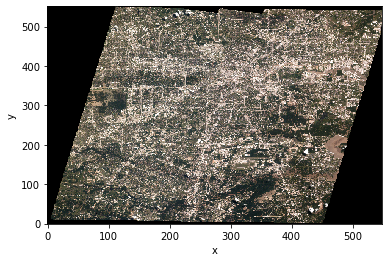

In [52]:
da.plot.imshow(rgb='channel')

### Related Intake plugins

- [Intake-ESM](https://intake-esm.readthedocs.io/en/latest/): Intake driver for loading catalogs of climate model data, intake-esm.readthedocs.io
- [Pangeo-Datastore](https://pangeo-data.github.io/pangeo-datastore/): Pangeo's public Intake catalog
- [Sat-Search](https://github.com/sat-utils/sat-search): Search and discovery of STAC catalogs, with plugin support to intake-stac